<a href="https://colab.research.google.com/github/csnj14/1era_tarea-/blob/master/Airplane_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.2.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/airplanes.zip" 

In [ ]:
# import packages including VGG16 as we saw in the class
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

In [ ]:
#display images and convert to rgb color

def plt_imshow(title, image):

	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
class Config:


#define the base path to the input dataset and then use it to derive and the images directory


    BASE_PATH = "dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
    ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])
    BASE_OUTPUT = "output"

#define the path to the output serialized model, model training plot and testing image filenames
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
    TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

#initialize our initial learning rate, number of epochs to train
  
    INIT_LR = 1e-4
    NUM_EPOCHS = 25
    BATCH_SIZE = 32

config = Config()

In [ ]:
#Implementing boundig box training  

#load the contents of the CSV annotations file
print("[INFO] Loading...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")

# initialize the list of images 

data = []
targets = []
filenames = []

[INFO] loading dataset...


In [ ]:

for row in rows:
#break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row


	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]

# scale the bounding box coordinates 

	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

# load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)

# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [ ]:
# convert the data and targets to NumPy arrays pixel intensities [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# training and testing splits using 90% of the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write the testing filenames to disk so that we can use then when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers 
vgg.trainable = False

# flatten the max-pooling in vgg
flatten = vgg.output
flatten = Flatten()(flatten)

#construct a fully-connected layer header to output the predicted

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# initialize the optimizer, compile the model

opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")


In [ ]:
# construct the argument parser and parse the arguments

args = {
    "input": "output/test_images.txt"
}

In [ ]:
# determine the input file type, but assume that we're working with single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

# if the file type is a text file, then we need to process *multiple* images
if "text/plain" == filetype:
	
	filenames = open(args["input"]).read().strip().split("\n")
	imagePaths = []

	
	for f in filenames:
# construct the full path to the image filename and then update our image paths list
		p = os.path.sep.join([config.IMAGES_PATH, f])
		imagePaths.append(p)

[INFO] loading object detector...


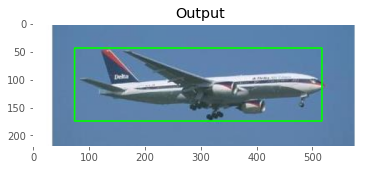

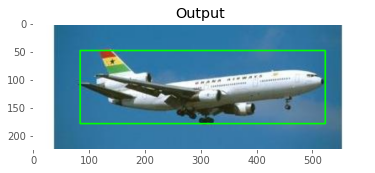

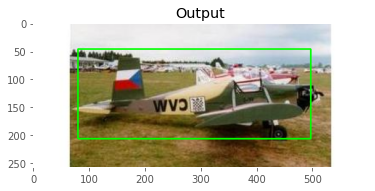

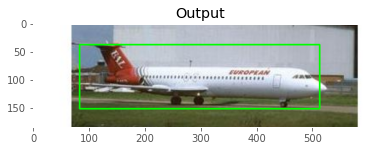

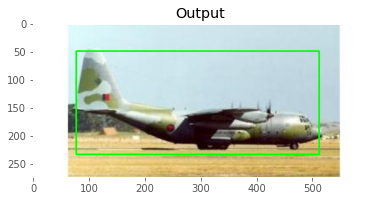

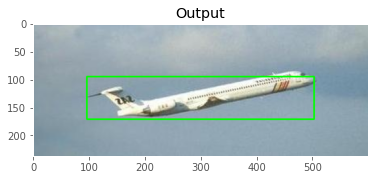

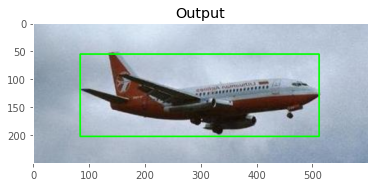

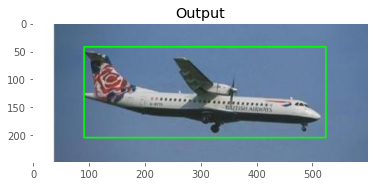

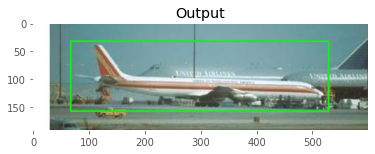

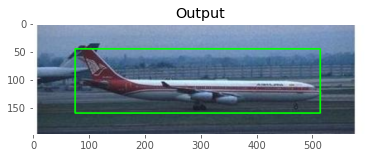

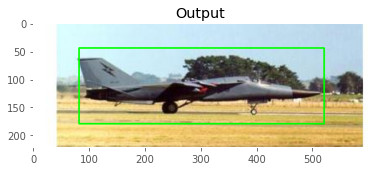

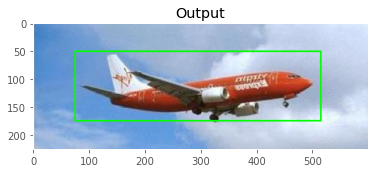

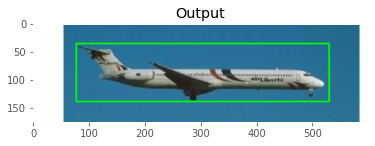

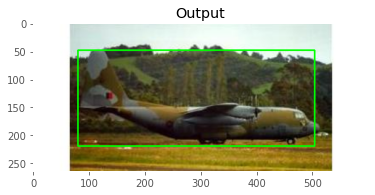

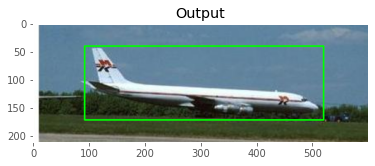

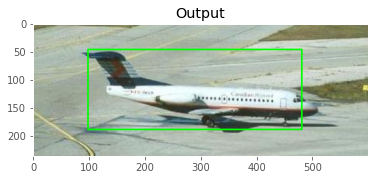

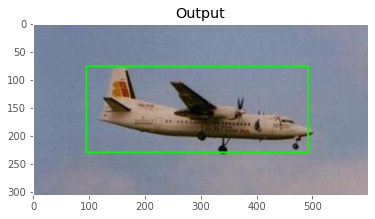

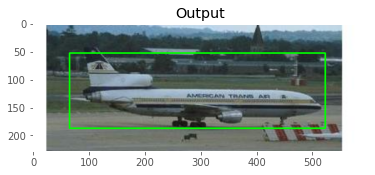

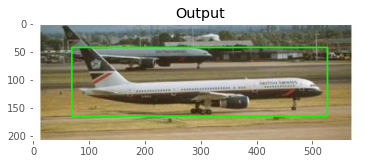

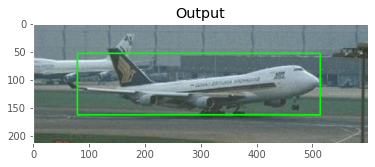

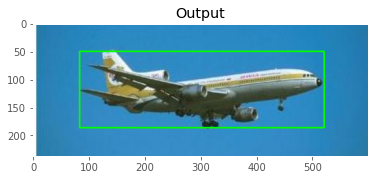

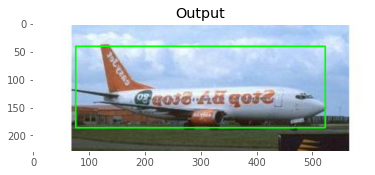

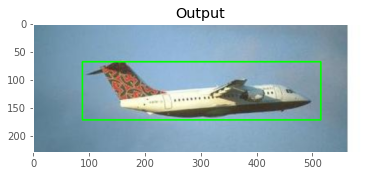

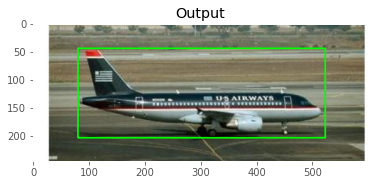

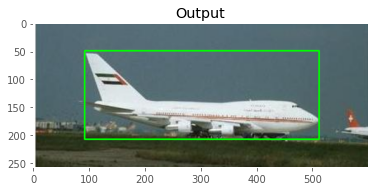

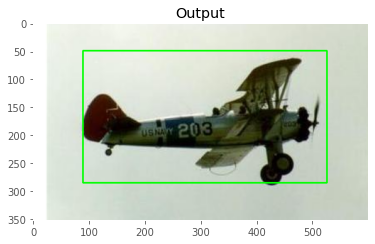

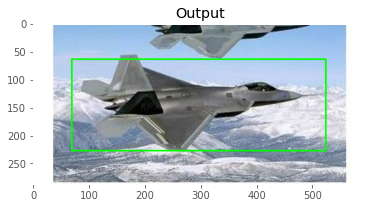

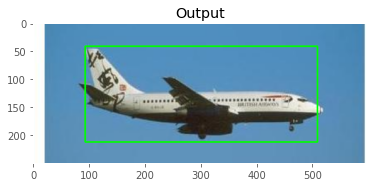

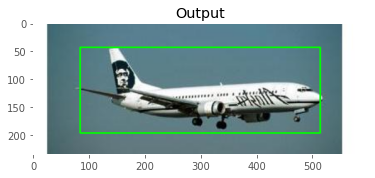

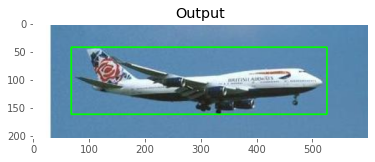

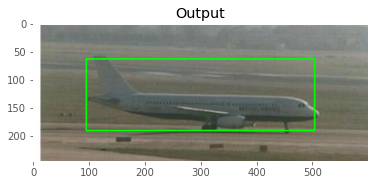

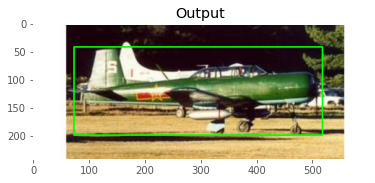

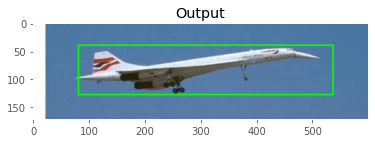

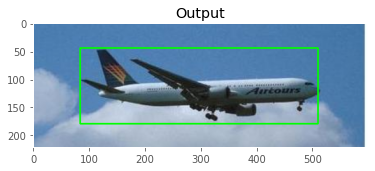

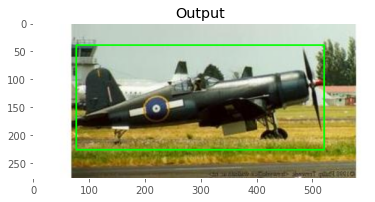

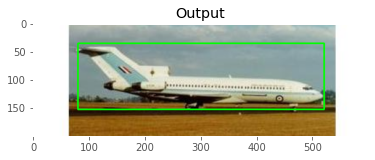

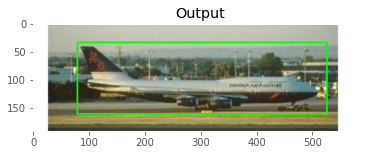

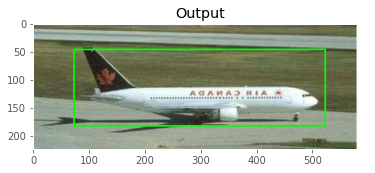

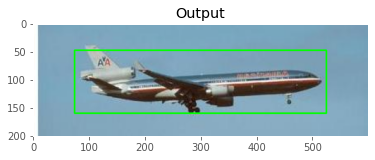

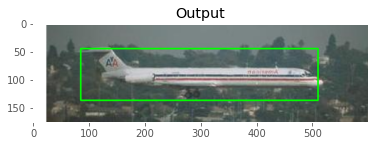

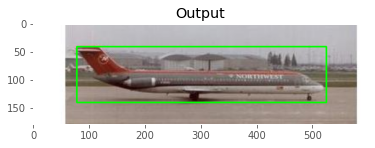

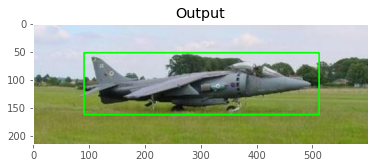

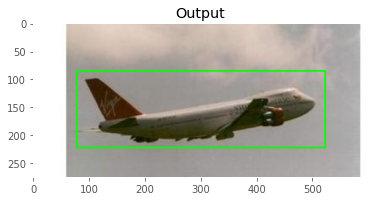

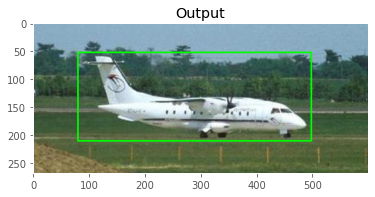

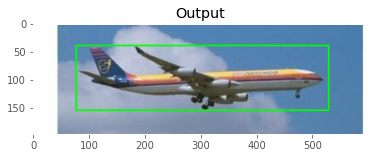

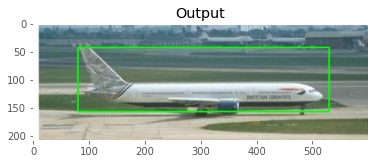

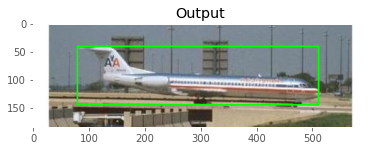

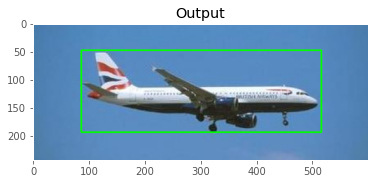

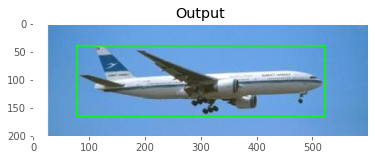

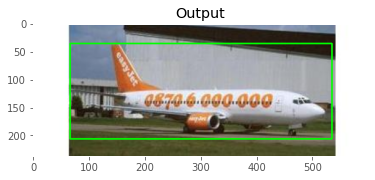

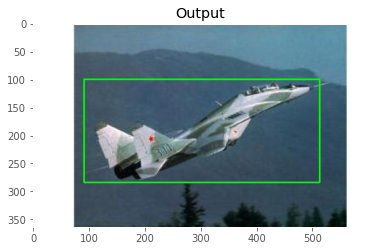

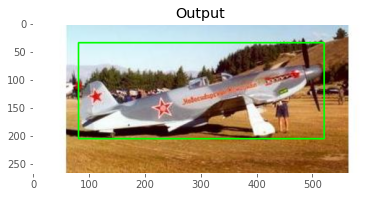

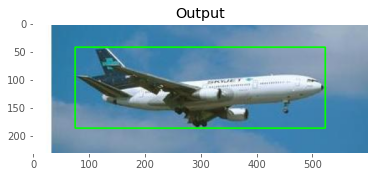

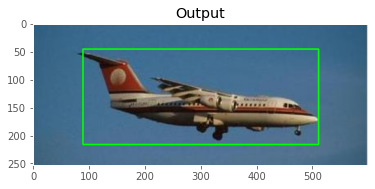

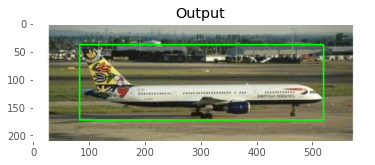

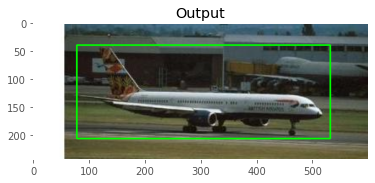

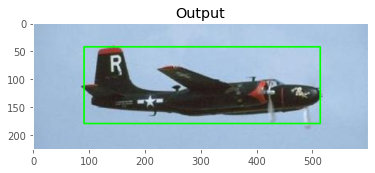

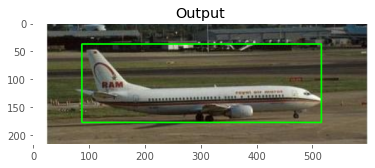

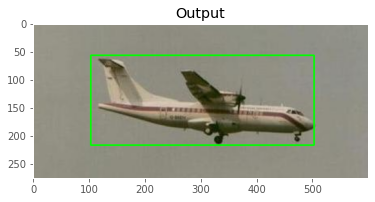

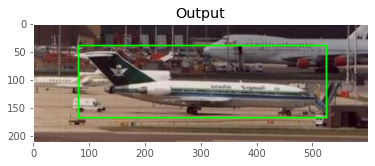

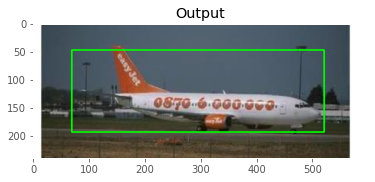

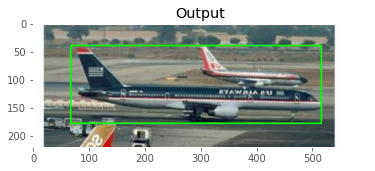

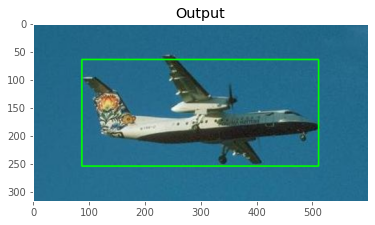

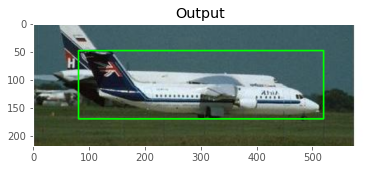

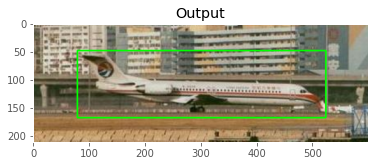

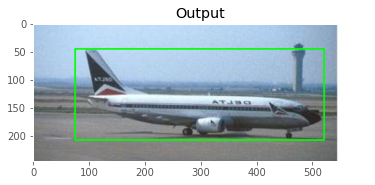

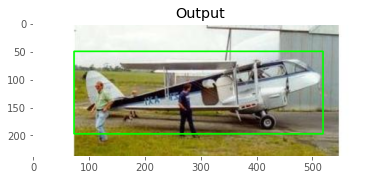

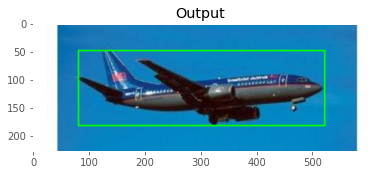

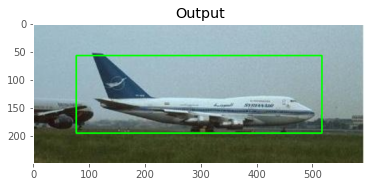

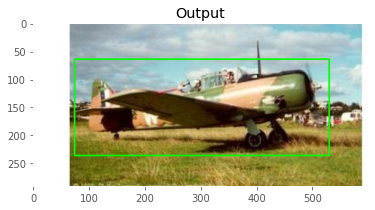

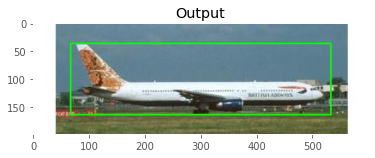

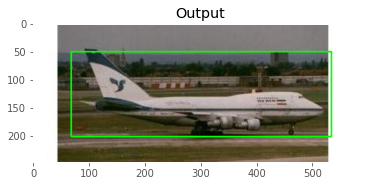

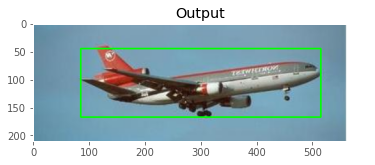

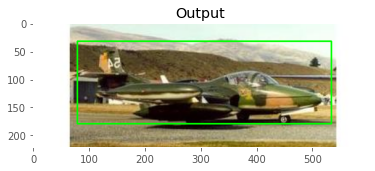

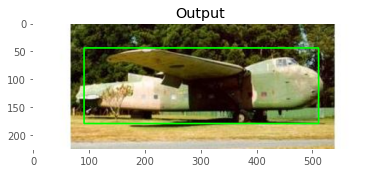

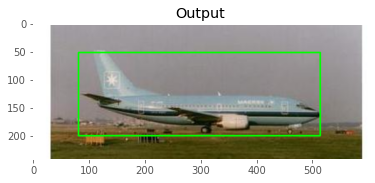

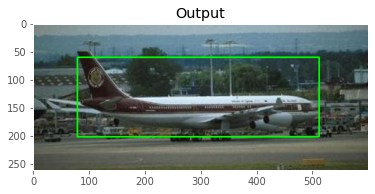

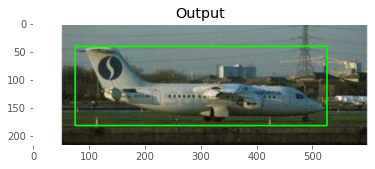

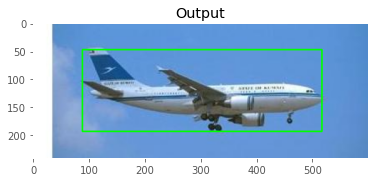

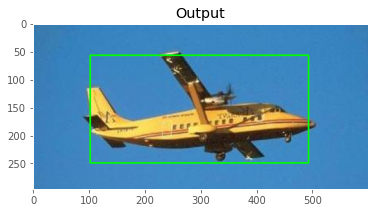

In [ ]:
# load trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(config.MODEL_PATH)

# loop over the images that we'll be testing using our bounding box

for imagePath in imagePaths:

	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)


	preds = model.predict(image)[0]
	(startX, startY, endX, endY) = preds

# load the input image (in OpenCV format)
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

# scale the predicted bounding box coordinates based on the image and dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)

	# draw the predicted bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)

	plt_imshow("Output", image)